<a href="https://colab.research.google.com/github/atanilson/Comp702_Final/blob/main/COMP702_GettingSatteliteIMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading satellite imagery from Google Earth Engine


In [1]:
%%capture
!pip -q install geojson
!pip -q install rasterio
!pip -q install eeconvert

In [2]:
# Libraries
import requests
import pandas as pd
import numpy as np
from PIL import Image
import geopandas as gpd
import geojson
import rasterio as rio
from rasterio.plot import show
import ee
import eeconvert as eec
import geemap
import folium

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Authenticating in Google Earth Engine

In [4]:
ee.Authenticate()
ee.Initialize(project="ee-atanilsont")

# Downloading boundaries of the country of interest

Using geoBoundaries API

https://www.geoboundaries.org/api.html#api

END Point - https://www.geoboundaries.org/api/current/[RELEASE-TYPE]/[3-LETTER-ISO-CODE]/[BOUNDARY-TYPE]/

In [5]:
# Country and admin level
country = "GBR"
level = "ADM3"

# Using the API provide
url = f"https://www.geoboundaries.org/api/current/gbOpen/{country}/{level}"

download_path = requests.get(url).json()["gjDownloadURL"]

#Saving the results
boundaries = requests.get(download_path).json()
with open("uk.geojson", "w") as file:
    geojson.dump(boundaries, file)

boundaries=gpd.read_file("uk.geojson")

In [6]:
city_name = "Liverpool" #2025-05-01, 2025-05-11*,2025-05-13,2025-05-15, 2025-05-16, 2025-06-20,2025-07-12 ***S2_H: 2025-07-12, 2025-05-16
#shape_name = "North East Lincolnshire"#S2_H: 2025-07-11
#shape_name = "North Yorkshire"
#shape_name = "Norfolk" #S1_SR_H: 2025-05-09, 2025-05-12,2025-06-11, 2025-06-21, 2025-07-11*** #S2_H: 2025-07-11, 2025-06-11, 2025-05-20, 2025-05-12
#shape_name = "Cumbria" #
#shape_name = "Cornwall" #2025-07-12, 2025-07-10,2025-05-18,
#shape_name = "Herefordshire, County of" #mo
#Worcestershire,'Warwickshire','Devon'
#shape_name = "Worcestershire" #2025-07-12,2025-07-11, 2025-06-19,
#geoboundary=gpd.read_file("geoboundary.geojson")

# Google Earth Engine

In [7]:
def generate_image_from_date(
        region,
        specific_date="2024-06-13",
        product="COPERNICUS/S2_SR_HARMONIZED",
        range_min=0,
        range_max=2000,
        cloud_pct=100
    ):
    # get the start and end of the day
    start_date = ee.Date(specific_date)
    end_date = start_date.advance(1, 'day')

    # Finding using filter
    image = ee.ImageCollection(product)\
            .filterBounds(region)\
            .filterDate(start_date, end_date)\
            .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
            .first()

    # obtaing the RGB image
    image = ee.Image(image).visualize(bands=["B4", "B3", "B2"], min=range_min, max=range_max)

    return image.clip(region)

In [ ]:
## Generating and VIsualizing

In [8]:
# Getting the shape
city = boundaries.loc[boundaries.shapeName == city_name]
centroid = city.iloc[0].geometry.centroid.coords[0]
city = eec.gdfToFc(city) #geodataframe to feature collection

image1 = generate_image_from_date(
    city,
    specific_date="2025-07-12",  #2025-07-11
    product="COPERNICUS/S2_HARMONIZED",#"COPERNICUS/S2_SR_HARMONIZED",
    range_min=0,
    range_max=2000,
    cloud_pct=50
)

#Visualize map
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10, use_folium=True)
Map.addLayer(city, {}, city_name)
Map.addLayer(image1, {}, "Sentinel2")
Map.addLayerControl()
Map

Map(center=[53.40433052645946, -2.9162212573496853], controls=(WidgetControl(options=['position', 'transparent…

# Exporting Image to google drive

In [ ]:
def save_image(image, filename, region, folder):
    task = ee.batch.Export.image.toDrive(
        image=image,
        driveFolder = folder,
        scale=10,
        region=region.geometry(),
        description=filename,
        fileFormat="GeoTIFF",
        crs="EPSG:4326",
        maxPixels=900000000
    )
    task.start()
    return task

In [ ]:
folder = "Colab Notebooks"
task = save_image(image1, "Liverpool", city, folder)

In [ ]:
#task.cancel()
task.status()

# Vizualizing the downloaded imageMM

<Axes: >

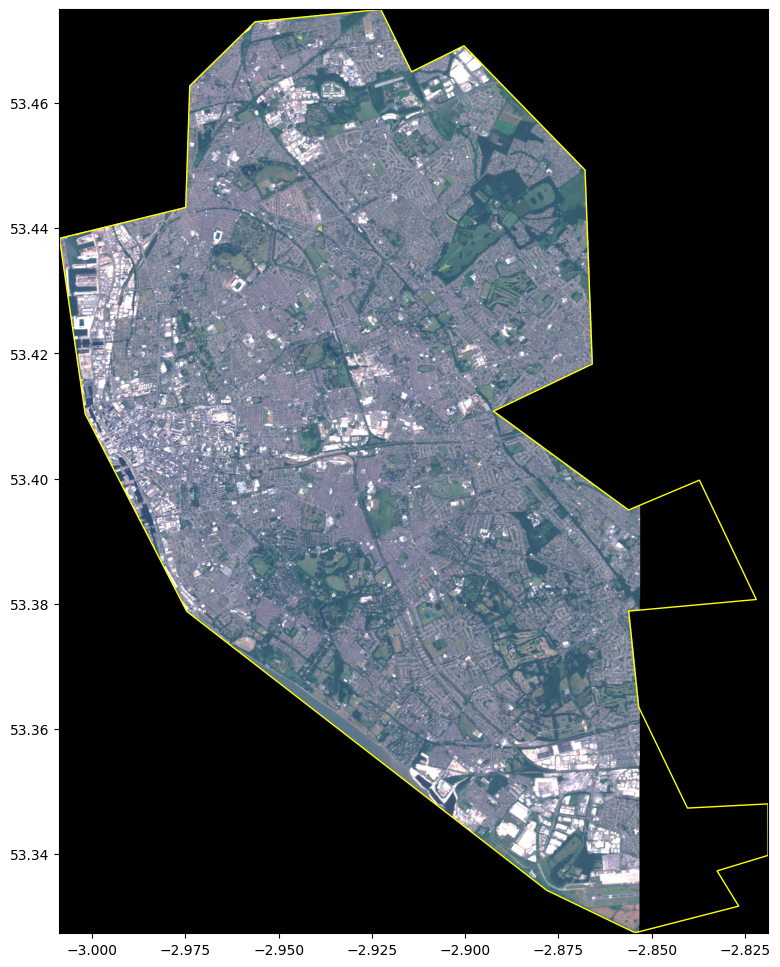

In [ ]:
image = rio.open("./drive/My Drive/colab Notebooks/Liverpool20250712_L1A.tif")
boundary = boundaries[boundaries.shapeName == city_name]

# Plot image and boundaries
fig, ax = plt.subplots(figsize=(12,12))
show(image, ax=ax)
boundary.plot(facecolor="none", edgecolor="yellow", ax=ax)